In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [2]:
tickers = [
    'HDFCBANK.NS', 'RELIANCE.NS', 'ICICIBANK.NS', 'INFY.NS', 
    'BHARTIARTL.NS', 'ITC.NS', 'TCS.NS', 'LT.NS', 
    'AXISBANK.NS', 'SBIN.NS', 'KOTAKBANK.NS', 'HINDUNILVR.NS', 
    'M&M.NS', 'MARUTI.NS', 'BAJFINANCE.NS'
]

In [3]:
raw_data = yf.download(tickers, start="2020-01-01", end="2024-12-31", auto_adjust=True)

[*********************100%***********************]  15 of 15 completed


In [4]:
stock_df = raw_data["Close"].copy()
stock_df.reset_index(inplace=True)
stock_df.columns.name = None
stock_df.dropna(inplace=True)

In [5]:
stock_df.head()

,Date,AXISBANK.NS,BAJFINANCE.NS,BHARTIARTL.NS,HDFCBANK.NS,HINDUNILVR.NS,ICICIBANK.NS,INFY.NS,ITC.NS,KOTAKBANK.NS,LT.NS,M&M.NS,MARUTI.NS,RELIANCE.NS,SBIN.NS,TCS.NS
0,2020-01-01,745.586914,413.532166,433.316467,605.529358,1749.931519,519.137939,633.151062,177.029160,1667.085449,1192.206787,509.727936,6945.335449,675.324280,308.602600,1900.037964
1,2020-01-02,753.802612,414.973755,435.132751,609.389099,1751.286987,522.861572,631.303650,178.330276,1664.595825,1224.379272,512.815125,6962.575195,686.821289,313.077759,1891.316284
2,2020-01-03,739.860840,409.833038,435.037109,600.698730,1741.708374,521.169006,641.013489,177.326599,1650.205811,1215.050781,506.070648,6890.763672,687.648865,307.910522,1929.008179
3,2020-01-06,720.242737,390.604309,429.827362,587.698792,1730.864624,508.450500,634.869690,174.798645,1645.674805,1198.395630,498.233917,6689.528320,671.700745,294.346619,1928.832764
4,2020-01-07,722.732361,391.674438,425.477966,597.004822,1735.608643,505.742401,625.460815,174.984512,1663.898682,1201.808472,500.276184,6719.165039,682.034546,293.792938,1933.565796


In [6]:
n = len(stock_df.columns) - 1
n

15

In [7]:
def price_scaling(prices_df):
    scaled_prices = stock_df.copy()
    for i in prices_df.columns[1:]:
        scaled_prices[i] = scaled_prices[i]/scaled_prices[i][0]
    return scaled_prices

In [8]:
def generate_portfolio_weights(n):
    weights = []
    for i in range(n):
        weights.append(random.random())
    weights = weights/np.sum(weights)
    return weights

In [9]:
def asset_allocation(df, weights, init_investment):
    portfolio_df = df.copy()
    scaled_df = price_scaling(df)
    for i, stock in enumerate(scaled_df.columns[1:]):
        portfolio_df[stock] = weights[i]*scaled_df[stock]*init_investment

    portfolio_df["Portfolio Value"] = portfolio_df[portfolio_df != "Date"].sum(axis=1, numeric_only=True)
    portfolio_df["Daily Return(%)"] = portfolio_df["Portfolio Value"].pct_change(1)*100
    portfolio_df.replace(np.nan,0,inplace=True)

    return portfolio_df

In [10]:
def simulation(weights, init_investment):
    portfolio_df = asset_allocation(stock_df, weights, init_investment)

    ROI = ((portfolio_df["Portfolio Value"][-1:]-portfolio_df["Portfolio Value"][0])/portfolio_df["Portfolio Value"][0])*100
    daily_return_df = portfolio_df.drop(columns = ["Date", "Portfolio Value", "Daily Return(%)"])
    daily_return_df = daily_return_df.pct_change(1)

    expected_portfolio_return = np.sum(weights*daily_return_df.mean())*252
    covariance = daily_return_df.cov()*252
    expected_vol = np.sqrt(np.dot(weights.T,np.dot(covariance,weights)))

    rf = 0.07
    sharpe_ratio = (expected_portfolio_return - rf)/expected_vol

    return expected_portfolio_return, expected_vol, sharpe_ratio, portfolio_df["Portfolio Value"][-1:].values[0], ROI.values[0]

In [11]:
sim_runs = 50000
initial_investment = 1000000

weights_runs = np.zeros((sim_runs,n))
sharpe_ratio_runs = np.zeros(sim_runs)
expected_portfolio_returns_runs = np.zeros(sim_runs)
volatility_runs = np.zeros(sim_runs)
ROI_runs = np.zeros(sim_runs)
final_value_runs = np.zeros(sim_runs)

for i in range(sim_runs):
    weights = generate_portfolio_weights(n)
    weights_runs[i,:] = weights
    expected_portfolio_returns_runs[i], volatility_runs[i], sharpe_ratio_runs[i], final_value_runs[i], ROI_runs[i] = simulation(weights, initial_investment)
    if (i%1000==0):
        print("Simulation Run = {}".format(i))   
        print("Weights = {}, Final Value = {:.2f}, Sharpe Ratio = {:.2f}".format(weights_runs[i].round(3), final_value_runs[i], sharpe_ratio_runs[i]))   
        print('\n')

Simulation Run = 0
Weights = [0.094 0.114 0.022 0.05  0.03  0.128 0.064 0.052 0.066 0.065 0.125 0.023
 0.122 0.029 0.017], Final Value = 2502509.98, Sharpe Ratio = 0.65


Simulation Run = 1000
Weights = [0.016 0.076 0.039 0.042 0.126 0.136 0.029 0.094 0.001 0.11  0.005 0.1
 0.063 0.079 0.084], Final Value = 2170966.91, Sharpe Ratio = 0.62


Simulation Run = 2000
Weights = [0.062 0.11  0.097 0.067 0.084 0.009 0.039 0.085 0.072 0.068 0.098 0.11
 0.001 0.028 0.069], Final Value = 2421378.01, Sharpe Ratio = 0.66


Simulation Run = 3000
Weights = [0.092 0.051 0.079 0.106 0.    0.1   0.089 0.05  0.025 0.107 0.087 0.045
 0.077 0.039 0.052], Final Value = 2559625.38, Sharpe Ratio = 0.71


Simulation Run = 4000
Weights = [0.015 0.117 0.02  0.138 0.092 0.029 0.119 0.015 0.002 0.055 0.058 0.059
 0.041 0.095 0.144], Final Value = 2279675.80, Sharpe Ratio = 0.63


Simulation Run = 5000
Weights = [0.058 0.172 0.07  0.112 0.065 0.064 0.066 0.074 0.013 0.045 0.08  0.077
 0.    0.067 0.037], Final Valu

In [12]:
max_sharpe_index = sharpe_ratio_runs.argmax()
min_vol_index = volatility_runs.argmin()

max_sharpe = sharpe_ratio_runs[max_sharpe_index]
max_sharpe_return = expected_portfolio_returns_runs[max_sharpe_index]
max_sharpe_vol = volatility_runs[max_sharpe_index]
max_sharpe_value = final_value_runs[max_sharpe_index]
max_sharpe_ROI = ROI_runs[max_sharpe_index]

In [13]:
print("Maximum Sharpe Portfolio")
print(f"Sharpe Ratio: {max_sharpe:.2f}")
print(f"Expected Annual Return: {max_sharpe_return*100:.2f}%")
print(f"Expected Volatility: {max_sharpe_vol*100:.2f}%")
print(f"Final Value: Rs.{max_sharpe_value:.2f}")
print(f"ROI: {max_sharpe_ROI:.2f}%")

Maximum Sharpe Portfolio
Sharpe Ratio: 0.96
Expected Annual Return: 24.99%
Expected Volatility: 18.73%
Final Value: Rs.3062919.12
ROI: 206.29%


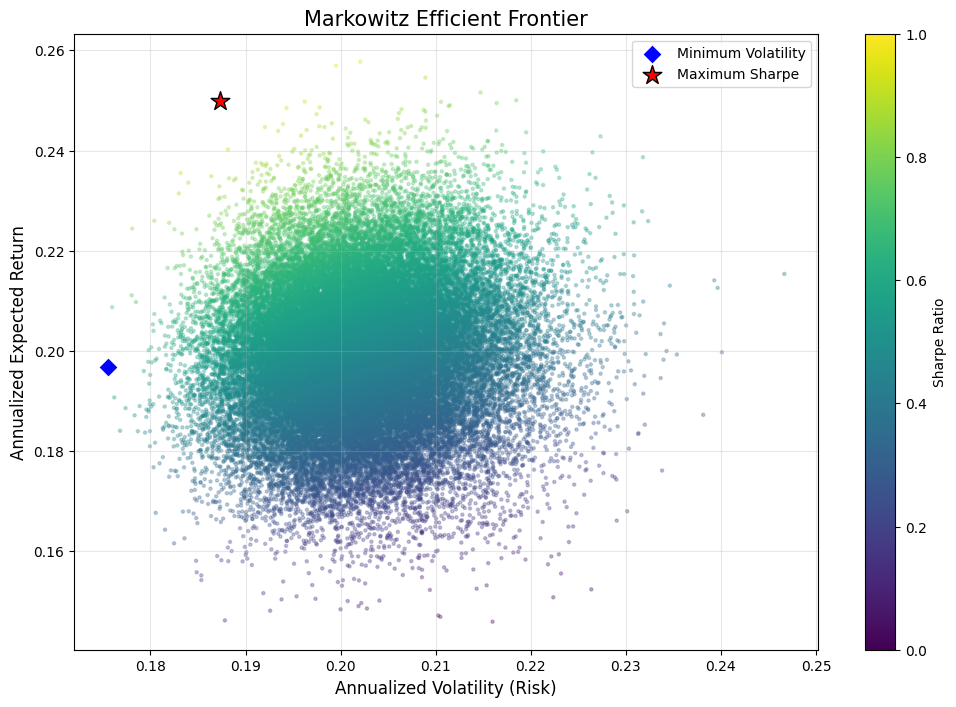

In [19]:
plt.figure(figsize=(12, 8))

plt.scatter(volatility_runs, expected_portfolio_returns_runs, 
            c=sharpe_ratio_runs, cmap='viridis', 
            s=5, alpha=0.3, zorder=1)

plt.scatter(volatility_runs[min_vol_index], expected_portfolio_returns_runs[min_vol_index], 
            color='blue', marker='D', s=100, label='Minimum Volatility', 
            edgecolors='white', zorder=2)

plt.scatter(max_sharpe_vol, max_sharpe_return, 
            color='red', marker='*', s=200, label='Maximum Sharpe', 
            edgecolors='black', zorder=3)

plt.colorbar(label='Sharpe Ratio')
plt.title('Markowitz Efficient Frontier', fontsize=15)
plt.xlabel('Annualized Volatility (Risk)', fontsize=12)
plt.ylabel('Annualized Expected Return', fontsize=12)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

plt.autoscale(enable=True, axis='both', tight=None)

plt.show()

In [15]:
optimal_weights = weights_runs[max_sharpe_index]
weights_df = pd.DataFrame({
    'Ticker': tickers,
    'Weight (%)': (optimal_weights * 100).round(2)
})

print(weights_df.sort_values(by='Weight (%)', ascending=False))

           Ticker  Weight (%)
2    ICICIBANK.NS       17.67
9         SBIN.NS       16.92
10   KOTAKBANK.NS       14.10
7           LT.NS       12.47
6          TCS.NS       12.16
4   BHARTIARTL.NS        6.19
11  HINDUNILVR.NS        4.80
14  BAJFINANCE.NS        4.68
8     AXISBANK.NS        4.24
3         INFY.NS        2.63
5          ITC.NS        2.22
12         M&M.NS        0.86
0     HDFCBANK.NS        0.66
13      MARUTI.NS        0.31
1     RELIANCE.NS        0.11
